In [205]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

"""
Récupération des rendements des actifs du DJIA
""" 

def get_rendements(stocks,début,fin): #date=yyyy-mm-dd en string
    prix=pdr.get_data_yahoo(stocks,start=début,end=fin)['Close'] 
    returns=prix.pct_change()
    logrdt=np.log(1+returns)*100
    logrdt=logrdt.iloc[1:]
    returns=returns.iloc[1:]
    prix=prix.iloc[1:]
    return  returns, prix, logrdt

stocks=['AAPL','AXP','BA', 'CAT', 'CSCO', 'CVX','DD','DIS','GE','HD','HPQ','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PFE','PG','RTX','T','TRV','UNH','VZ','WMT','XOM']
début='2000-01-03'
fin='2014-12-31'

output=get_rendements(stocks, début, fin)
rendements=output[0]
prix=output[1]
rdt_log=output[2]

C:\Users\baptc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [213]:
"""
Méthode Single best

"""

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime





def Tick_Loss(u,alpha):
    """
    Fonction de perte aymétrique et par morceaux de Giacomini et Komunjer (2005)
    """ 
    
    if u<=0:
        y=1
    else:
        y=0
        
    return (alpha-y)*u  


def Single_Best(M_previsions, rdt,alpha=0.01):
    
    # Calcul du nombre de lignes
    t=M_previsions.shape[0]
    # Calcul du nombre de colonnes
    M=M_previsions.shape[1]
    # Creation de la matrice des Betas de chaque date, pour chaque méthode
    beta_weight=np.zeros((t,M))
    
    
    # Création d'une matrice contenant les pertes de tick des différents modèles de VaR
    tick_losses=np.zeros((t,M))

    for i in range(0,M):
            tick_losses[0,i]=Tick_Loss(rdt.iloc[0]-M_previsions.iloc[0,i],alpha)
    
    # Détermination du classement de chaque actif
    argsort_array=(tick_losses[0,:]).argsort()
    ranks_array = np.empty_like(argsort_array)
    ranks_array[argsort_array] = np.arange(M)
    
    # Boucle attribuant un poids uniquement au meilleur modèle de la première période
    for l in ranks_array:
        if (ranks_array[l])>0:
            beta_weight[0,l]=0
        else:
            beta_weight[0,l]=1
            
    # Calcul de la perte par rapport aux réalisations du portefeuille
    for j in range(1,t):
        for i in range(0,M):
            tick_losses[j,i]=tick_losses[j-1,i]+Tick_Loss(rdt.iloc[j]-M_previsions.iloc[j,i],alpha)
      
        # Détermination du classement de chaque actif
        argsort_array=(tick_losses[j,:]).argsort()
        ranks_array = np.empty_like(argsort_array)
        ranks_array[argsort_array] = np.arange(M)
    
    
        # Boucle attribuant un poins uniquement au meilleur modèle
        for k in ranks_array:
            if (ranks_array[k])>0:
                 beta_weight[j,k]=0
            else:
                 beta_weight[j,k]=1
    
   


    
    
    return beta_weight


In [ ]:
"""
Calcul de la VaR
"""

from pandas import*
import os
path = os. getcwd()

VaR_Simple_best=np.zeros((3772,30))

# Ouverture de chaque fichier csv contenant les résultats des VaR standalone des 30 actifs
for i in range(0,30):
    mypath='{}/Assets/models_asset_{}.csv'.format(path,i)
    file=read_csv(mypath)
    
    
    Beta=Single_Best(file.iloc[0:3772,1:18], rdt_log.iloc[:,i],alpha=0.01)

    valeur=np.zeros((3772,18))
    valeur=file.iloc[0:3772,1:18]

    VaR=np.multiply(Beta[:,:],valeur.iloc[0:3772,:])
    
    
    # Matrice des résultats
    VaR_Simple_best[:,i]=VaR.sum(axis=1)

In [215]:
file
import numpy as np




    
VaR_Simple_best=DataFrame(VaR_Simple_best[1758:3771],index=file['dates'].iloc[1759:3772],columns=stocks)

In [190]:


# Fonction qui calcule le pourcentage de fois ou un rendement a été inférieur à la VAR
# La fonction crée 3 graphiques pour les trois périodes
# Les inputs sont des data frame : var_1 correspond aux VAR forecast de la 1ère période
# rdt_log_1 correspond aux rendements de la période 1
# même principe pour le reste 
# name correspond au nom de la méthode utilisé
def kupiec(var_1,rdt_log_1,var_2,rdt_log_2,var_3,rdt_log_3,name):
    
    '''c'est la partie 1 du graphique'''
    var=var_1
    rdt_log=rdt_log_1
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): #on s'interesse à tous les actifs
        rdt_logs=rdt_log.iloc[:,j]
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            #pour savoir si la Var a joué son rôle ou pas
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    
    val=resu
    
    values=np.ones(len(rdt_log.columns))*0.005 #ici c'est pour tous les actifs
    plt.figure(figsize=(10, 0.5))
    un=plt.subplot(1,3,1)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2014',fontsize=8)
    plt.ylabel(name, fontsize=8)
    
    '''c'est la partie 2 du graphique'''
    #c'est quasiement le même code que pour la première partie du graphique
    var=var_2
    rdt_log=rdt_log_2
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1

        final=a/p_un
        resu.append(final)
    val=resu
    values=np.ones(len(rdt_log.columns))*0.005 


    deux=plt.subplot(1,3,2)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2007 au 31.12.2010',fontsize=8)
    
    
    var=var_3
    rdt_log=rdt_log_3
    
    resu=[]
    p_un=rdt_log.shape[0]
    for j in range(0,len(rdt_log.columns)): 
        rdt_logs=rdt_log.iloc[:,j]
        
        var_s=var.iloc[:,j]
        a=0
        for i in range(0,p_un):
            varr=var_s.iloc[i]
            rdt=rdt_logs.iloc[i]

            g_rdt=float(rdt)
            g_var=float(varr)
            
            if g_var>g_rdt:
                a=a+1
        final=a/p_un
        resu.append(final)
    val=resu
    
    
    '''c'est la partie 3 du graphique'''
    values=np.ones(len(rdt_log.columns))*0.005 

    trois=plt.subplot(1,3,3)
    plt.scatter(val, values, s=20)
    plt.xticks([0.01,0.02,0.03])
    plt.yticks([])
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.01)
    plt.axvline(x=0.01-2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01+2.58*(0.01*0.99/p_un)**0.5,color='black')
    plt.axvline(x=0.01,color='grey')
    plt.title('période du 03.01.2011 au 31.12.2014',fontsize=8)

    
    plt.show()

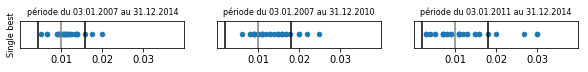

In [216]:
import matplotlib.pyplot as plt

kupiec(VaR_Simple_best,rdt_log.iloc[1758:3771:,:],VaR_Simple_best,rdt_log.iloc[1758:2766,:],VaR_Simple_best,rdt_log.iloc[2767:3771,:],"Single best")

In [217]:
VaR_Simple_best.to_csv("Single Best Results 2007-2014.csv")